In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import dask
from datetime import datetime, timedelta

from xscale import signal
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:107: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/numba/core/errors.py:149: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


### Load datasets

In [2]:
ecco = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/')

In [5]:
#budgFw = xr.open_dataset('/mnt/efs/data/ecco/eccov4r3_budg_fw.nc').budg_fw
#budgH = xr.open_dataset('/mnt/efs/data/ecco/eccov4r3_budg_heat.nc').budg_heat
budgFw = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_fw.nc').budg_fw
budgH = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_heat.nc').budg_heat

In [6]:
dif_ConvFw = budgFw.sel(term='tendFw') - budgFw.sel(term='totalFw')
budgFw = xr.concat([budgFw, dif_ConvFw.assign_coords(term='dif_ConvFw')], dim='term')

## Version 1: Integrate tendencies

In [7]:
budgFw_int = (budgFw.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')
budgH_int = (budgH.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')

budgFw_int = budgFw_int.reset_coords(drop=True)
budgH_int = budgH_int.reset_coords(drop=True)

In [8]:
budgFw_dtr = signal.fitting.detrend(budgFw_int, dim='time', type='linear')
budgH_dtr = signal.fitting.detrend(budgH_int, dim='time', type='linear')

In [9]:
budgFw_anom = ale
budgH_anom = budgH_dtr.groupby('time.month') - budgH_dtr.groupby('time.month').mean('time')

/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]
/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]


### Plot

In [10]:
class OffsetYearLocator(dates.YearLocator):
    def __init__(self, *args, **kwargs):
        self.offset = kwargs.pop("offset", 0)
        dates.YearLocator.__init__(self,*args, **kwargs)
    def tick_values(self, vmin, vmax):
        ymin = self.base.le(vmin.year) * self.base.step - self.offset
        ymax = self.base.ge(vmax.year) * self.base.step + (self.base.step-self.offset)
        ticks = [vmin.replace(year=ymin, **self.replaced)]
        while True:
            dt = ticks[-1]
            if dt.year >= ymax:
                return dates.date2num(ticks)
            year = dt.year + self.base.step
            ticks.append(dt.replace(year=year, **self.replaced))

def format_xaxis(ax):

    years = dates.YearLocator(10,month=1,day=1)
    years1=OffsetYearLocator(2,month=1,day=1, offset=1)
    dfmt = dates.DateFormatter('%Y')
    dfmt1 = dates.DateFormatter('%y')

    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_minor_locator(years1)
    ax.xaxis.set_major_formatter(dfmt)
    ax.xaxis.set_minor_formatter(dfmt1)
    ax.get_xaxis().set_tick_params(which='major', pad=15)

    plt.setp(ax.get_xmajorticklabels(), rotation=0, weight="bold", ha="center")

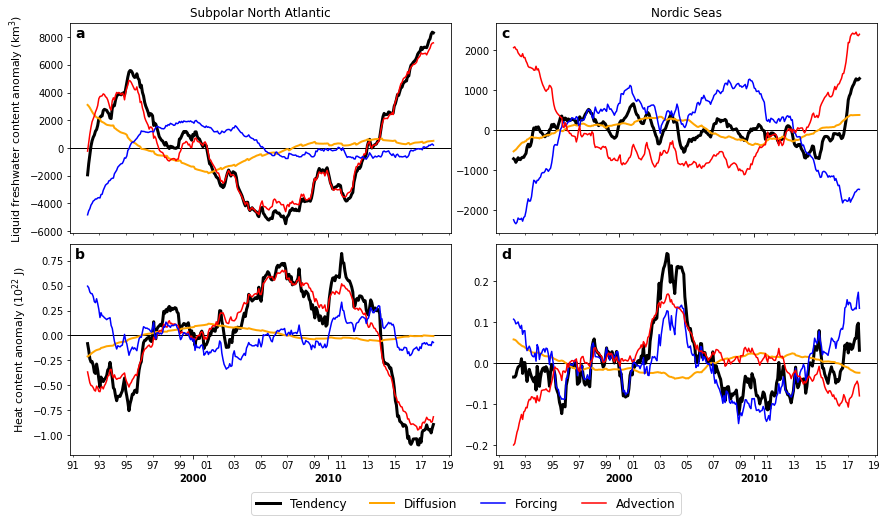

In [11]:
fig, axs = plt.subplots(2, 2,sharex=True, figsize=(14, 8))

axs[0,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='spna',term='tendFw')*1e-3, 
              lw=3, color='black',label='Tendency')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='spna',term='dif_ConvFw')*1e-3, 
              lw=2, color='orange',label='Diffusion')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='spna',term='adv_ConvFw')*1e-3, 
              lw=1.5, color='red',label='Advection')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='spna',term='forcFw')*1e-3, 
              lw=1.5, color='blue',label='Forcing')
axs[0,0].set_ylabel(r'Liquid freshwater content anomaly (km$^3$)',fontsize=11)

axs[0,0].text(0.013,0.93, 'a', fontsize=14, fontweight='bold', transform=axs[0,0].transAxes)
axs[0,0].set_title(r'Subpolar North Atlantic', fontsize=12)

axs[1,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='spna',term='tendH')*1e-22, 
              lw=3, color='black',label='Tendency')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='spna',term='dif_ConvH')*1e-22, 
              lw=2, color='orange',label='Diffusion')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='spna',term='adv_ConvH')*1e-22, 
              lw=1.5, color='red',label='Advection')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='spna',term='forcH')*1e-22, 
              lw=1.5, color='blue',label='Forcing')

axs[1,0].set_ylabel(r'Heat content anomaly (10$^{22}$ J)', fontsize=11)
axs[1,0].text(0.013,0.93, 'b', fontsize=14, fontweight='bold', transform=axs[1,0].transAxes)
format_xaxis(axs[1,0])

axs[0,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,1].plot(budgFw_anom.time, budgFw_anom.sel(region='nsea',term='tendFw')*1e-3, 
              lw=3, color='black',label='Tendency')
axs[0,1].plot(budgFw_anom.time, budgFw_anom.sel(region='nsea',term='dif_ConvFw')*1e-3, 
              lw=2, color='orange',label='Diffusion')
axs[0,1].plot(budgFw_anom.time, budgFw_anom.sel(region='nsea',term='forcFw')*1e-3, 
              lw=1.5, color='blue',label='Forcing')
axs[0,1].plot(budgFw_anom.time, budgFw_anom.sel(region='nsea',term='adv_ConvFw')*1e-3, 
              lw=1.5, color='red',label='Advection')

axs[0,1].text(0.013,0.93, 'c', fontsize=14, fontweight='bold', transform=axs[0,1].transAxes)
axs[0,1].set_title(r'Nordic Seas', fontsize=12)

axs[1,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,1].plot(budgH_anom.time, budgH_anom.sel(region='nsea',term='tendH')*1e-22, 
              lw=3, color='black',label='Tendency')
axs[1,1].plot(budgH_anom.time, budgH_anom.sel(region='nsea',term='dif_ConvH')*1e-22, 
              lw=2, color='orange',label='Diffusion')
axs[1,1].plot(budgH_anom.time, budgH_anom.sel(region='nsea',term='forcH')*1e-22, 
              lw=1.5, color='blue',label='Forcing')
axs[1,1].plot(budgH_anom.time, budgH_anom.sel(region='nsea',term='adv_ConvH')*1e-22, 
              lw=1.5, color='red',label='Advection')

axs[1,1].text(0.013,0.93, 'd', fontsize=14, fontweight='bold', transform=axs[1,1].transAxes)
format_xaxis(axs[1,1])
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, hspace=0.05, wspace=0.12)
axs[1,1].legend(frameon=True, fancybox=True, bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=12)

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

## Version 2: Integrate anomalies

In [11]:
budgH_anom = budgH.groupby('time.month') - budgH.groupby('time.month').mean('time')
budgFw_anom = budgFw.groupby('time.month') - budgFw.groupby('time.month').mean('time')

In [12]:
budgFw_int = (budgFw_anom.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')
budgH_int = (budgH_anom.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')

In [13]:
budgFw_anom = budgFw_int - budgFw_int.mean('time')
budgH_anom = budgH_int - budgH_int.mean('time')

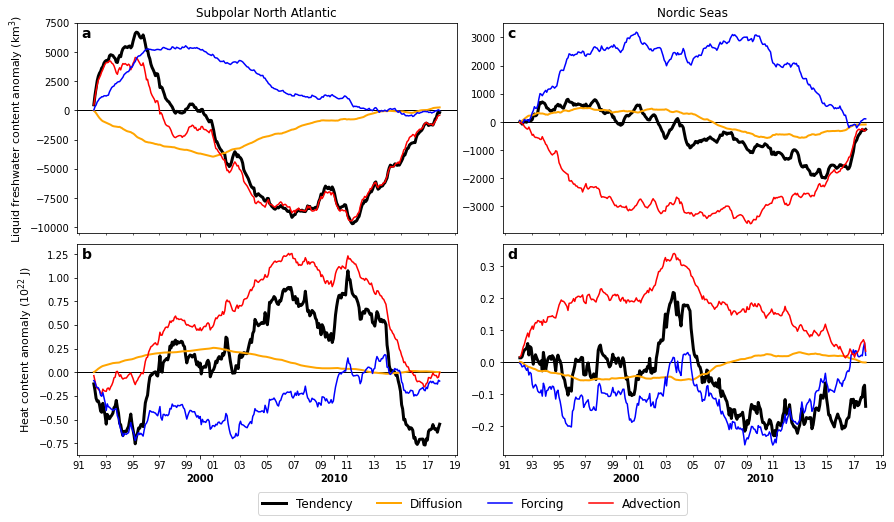

In [15]:
fig, axs = plt.subplots(2, 2,sharex=True, figsize=(14, 8))

axs[0,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,0].plot(budgFw_int.time, budgFw_int.sel(region='spna',term='tendFw')*1e-3, 
              lw=3, color='black',label='Tendency')
axs[0,0].plot(budgFw_int.time, budgFw_int.sel(region='spna',term='dif_ConvFw')*1e-3, 
              lw=2, color='orange',label='Diffusion')
axs[0,0].plot(budgFw_int.time, budgFw_int.sel(region='spna',term='adv_ConvFw')*1e-3, 
              lw=1.5, color='red',label='Advection')
axs[0,0].plot(budgFw_int.time, budgFw_int.sel(region='spna',term='forcFw')*1e-3, 
              lw=1.5, color='blue',label='Forcing')
axs[0,0].set_ylabel(r'Liquid freshwater content anomaly (km$^3$)',fontsize=11)
axs[0,0].text(0.013,0.93, 'a', fontsize=14, fontweight='bold', transform=axs[0,0].transAxes)
axs[0,0].set_title(r'Subpolar North Atlantic', fontsize=12)

axs[1,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,0].plot(budgH_int.time, budgH_int.sel(region='spna',term='tendH')*1e-22, 
              lw=3, color='black',label='Tendency')
axs[1,0].plot(budgH_int.time, budgH_int.sel(region='spna',term='dif_ConvH')*1e-22, 
              lw=2, color='orange',label='Diffusion')
axs[1,0].plot(budgH_int.time, budgH_int.sel(region='spna',term='adv_ConvH')*1e-22, 
              lw=1.5, color='red',label='Advection')
axs[1,0].plot(budgH_int.time, budgH_int.sel(region='spna',term='forcH')*1e-22, 
              lw=1.5, color='blue',label='Forcing')

axs[1,0].set_ylabel(r'Heat content anomaly (10$^{22}$ J)', fontsize=11)
axs[1,0].text(0.013,0.93, 'b', fontsize=14, fontweight='bold', transform=axs[1,0].transAxes)
format_xaxis(axs[1,0])

axs[0,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,1].plot(budgFw_int.time, budgFw_int.sel(region='nsea',term='tendFw')*1e-3, 
              lw=3, color='black',label='Tendency')
axs[0,1].plot(budgFw_int.time, budgFw_int.sel(region='nsea',term='dif_ConvFw')*1e-3, 
              lw=2, color='orange',label='Diffusion')
axs[0,1].plot(budgFw_int.time, budgFw_int.sel(region='nsea',term='forcFw')*1e-3, 
              lw=1.5, color='blue',label='Forcing')
axs[0,1].plot(budgFw_int.time, budgFw_int.sel(region='nsea',term='adv_ConvFw')*1e-3, 
              lw=1.5, color='red',label='Advection')

axs[0,1].text(0.013,0.93, 'c', fontsize=14, fontweight='bold', transform=axs[0,1].transAxes)
axs[0,1].set_title(r'Nordic Seas', fontsize=12)

axs[1,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,1].plot(budgH_int.time, budgH_int.sel(region='nsea',term='tendH')*1e-22, 
              lw=3, color='black',label='Tendency')
axs[1,1].plot(budgH_int.time, budgH_int.sel(region='nsea',term='dif_ConvH')*1e-22, 
              lw=2, color='orange',label='Diffusion')
axs[1,1].plot(budgH_int.time, budgH_int.sel(region='nsea',term='forcH')*1e-22, 
              lw=1.5, color='blue',label='Forcing')
axs[1,1].plot(budgH_int.time, budgH_int.sel(region='nsea',term='adv_ConvH')*1e-22, 
              lw=1.5, color='red',label='Advection')

axs[1,1].text(0.013,0.93, 'd', fontsize=14, fontweight='bold', transform=axs[1,1].transAxes)
format_xaxis(axs[1,1])
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, hspace=0.05, wspace=0.12)
axs[1,1].legend(frameon=True, fancybox=True, bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=12)

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


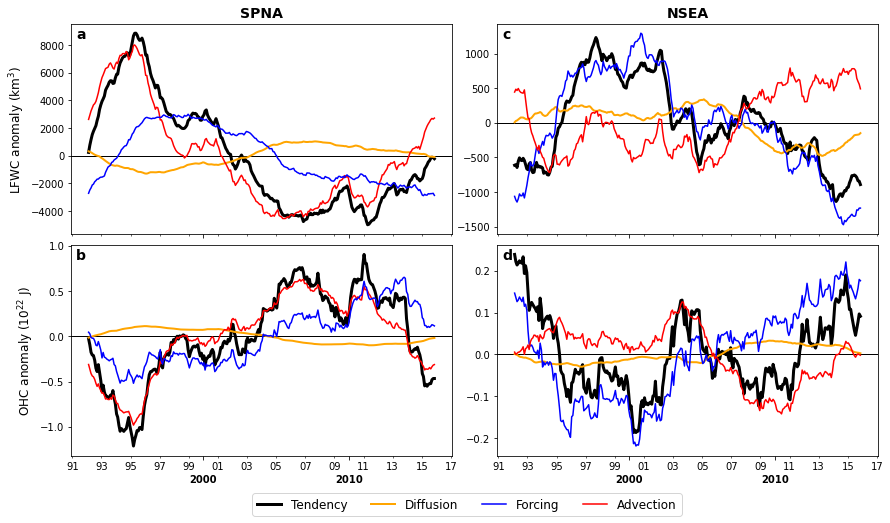

In [14]:
fig, axs = plt.subplots(2, 2,sharex=True, figsize=(14, 8))

axs[0,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='spna',term='tendFw')*1e-3, 
              lw=3, color='black',label='Tendency')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='spna',term='dif_ConvFw')*1e-3, 
              lw=2, color='orange',label='Diffusion')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='spna',term='adv_ConvFw')*1e-3, 
              lw=1.5, color='red',label='Advection')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='spna',term='forcFw')*1e-3, 
              lw=1.5, color='blue',label='Forcing')
axs[0,0].set_ylabel(r'LFWC anomaly (km$^3$)',fontsize=12)

axs[0,0].text(0.013,0.93, 'a', fontsize=14, fontweight='bold', transform=axs[0,0].transAxes)
axs[0,0].set_title(r'SPNA', fontsize=14, fontweight='bold')

axs[1,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='spna',term='tendH')*1e-22, 
              lw=3, color='black',label='Tendency')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='spna',term='dif_ConvH')*1e-22, 
              lw=2, color='orange',label='Diffusion')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='spna',term='adv_ConvH')*1e-22, 
              lw=1.5, color='red',label='Advection')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='spna',term='forcH')*1e-22, 
              lw=1.5, color='blue',label='Forcing')

axs[1,0].set_ylabel(r'OHC anomaly (10$^{22}$ J)', fontsize=12)
axs[1,0].text(0.013,0.93, 'b', fontsize=14, fontweight='bold', transform=axs[1,0].transAxes)
format_xaxis(axs[1,0])

axs[0,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,1].plot(budgFw_anom.time, budgFw_anom.sel(region='nsea',term='tendFw')*1e-3, 
              lw=3, color='black',label='Tendency')
axs[0,1].plot(budgFw_anom.time, budgFw_anom.sel(region='nsea',term='dif_ConvFw')*1e-3, 
              lw=2, color='orange',label='Diffusion')
axs[0,1].plot(budgFw_anom.time, budgFw_anom.sel(region='nsea',term='forcFw')*1e-3, 
              lw=1.5, color='blue',label='Forcing')
axs[0,1].plot(budgFw_anom.time, budgFw_anom.sel(region='nsea',term='adv_ConvFw')*1e-3, 
              lw=1.5, color='red',label='Advection')

axs[0,1].text(0.013,0.93, 'c', fontsize=14, fontweight='bold', transform=axs[0,1].transAxes)
axs[0,1].set_title(r'NSEA', fontsize=14, fontweight='bold')

axs[1,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,1].plot(budgH_anom.time, budgH_anom.sel(region='nsea',term='tendH')*1e-22, 
              lw=3, color='black',label='Tendency')
axs[1,1].plot(budgH_anom.time, budgH_anom.sel(region='nsea',term='dif_ConvH')*1e-22, 
              lw=2, color='orange',label='Diffusion')
axs[1,1].plot(budgH_anom.time, budgH_anom.sel(region='nsea',term='forcH')*1e-22, 
              lw=1.5, color='blue',label='Forcing')
axs[1,1].plot(budgH_anom.time, budgH_anom.sel(region='nsea',term='adv_ConvH')*1e-22, 
              lw=1.5, color='red',label='Advection')

axs[1,1].text(0.013,0.93, 'd', fontsize=14, fontweight='bold', transform=axs[1,1].transAxes)
format_xaxis(axs[1,1])
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, hspace=0.05, wspace=0.12)
axs[1,1].legend(frameon=True, fancybox=True, bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=12)

#plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

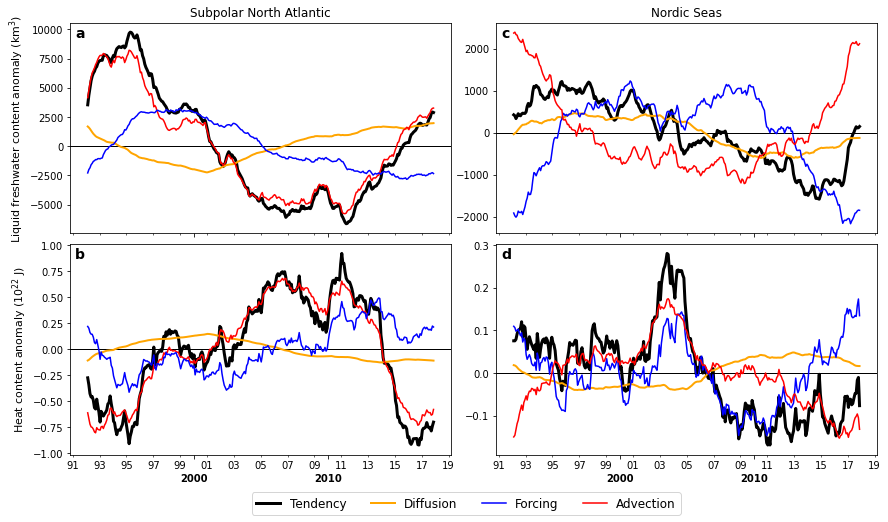

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


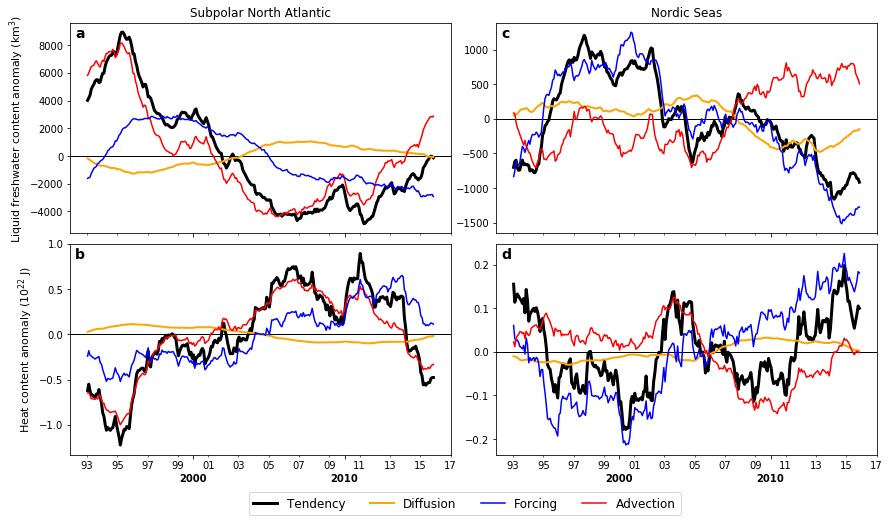

### Total area (SPNA+NSEA)

In [17]:
budgH = budgH.sel(region=['spna','nsea']).sum('region')
budgFw = budgFw.sel(region=['spna','nsea']).sum('region')

In [18]:
budgH_anom = budgH.groupby('time.month') - budgH.groupby('time.month').mean('time')
budgFw_anom = budgFw.groupby('time.month') - budgFw.groupby('time.month').mean('time')

In [19]:
budgFw_int = (budgFw_anom.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')
budgH_int = (budgH_anom.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')

In [20]:
budgFw_anom = budgFw_int - budgFw_int.mean('time')
budgH_anom = budgH_int - budgH_int.mean('time')

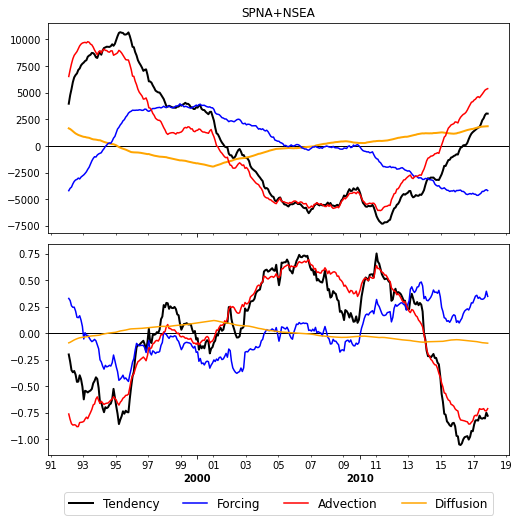

In [21]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

axs[0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0].plot(budgFw_anom.time, budgFw_anom.sel(term='tendFw')*1e-3, lw=2, color='black',label='Tendency')
axs[0].plot(budgFw_anom.time, budgFw_anom.sel(term='dif_ConvFw')*1e-3, lw=2, color='orange',label='Diffusion')
axs[0].plot(budgFw_anom.time, budgFw_anom.sel(term='forcFw')*1e-3, lw=1.5, color='blue',label='Forcing')
axs[0].plot(budgFw_anom.time, budgFw_anom.sel(term='adv_ConvFw')*1e-3, lw=1.5, color='red',label='Advection')
axs[0].set_title(r'SPNA+NSEA', fontsize=12)

axs[1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1].plot(budgH_anom.time, budgH_anom.sel(term='tendH')*1e-22, lw=2, color='black',label='Tendency')
axs[1].plot(budgH_anom.time, budgH_anom.sel(term='forcH')*1e-22, lw=1.5, color='blue',label='Forcing')
axs[1].plot(budgH_anom.time, budgH_anom.sel(term='adv_ConvH')*1e-22, lw=1.5, color='red',label='Advection')
axs[1].plot(budgH_anom.time, budgH_anom.sel(term='dif_ConvH')*1e-22, lw=1.5, color='orange',label='Diffusion')
format_xaxis(axs[1])
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, hspace=0.05, wspace=0.12)
axs[1].legend(frameon=True, fancybox=True, bbox_to_anchor=(0.98, -0.15), ncol=4, fontsize=12)

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

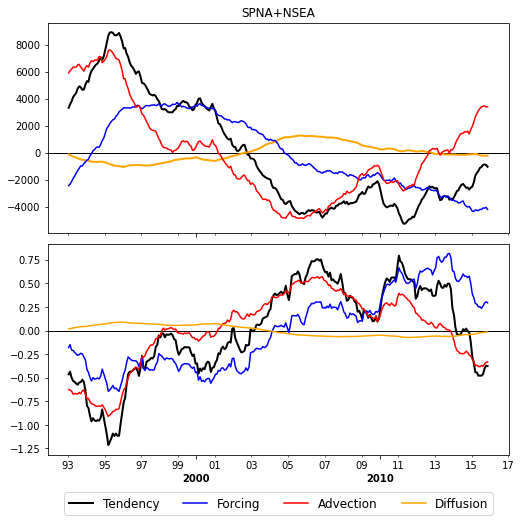